In [2]:
pip install metadata>=0.1

zsh:1: 0.1 not found


Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
os.chdir('/Users/cengbosen/Desktop/学习资料/my_code/')


In [4]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

from metadata.dataset import \
    ClassificationDataset, \
    ClassificationDatasetWithSaliency
from utils import imutils
from utils.imutils import Normalize

导入所需的库:

numpy 用于处理数组数据。
torch 是 PyTorch 深度学习框架。
DataLoader 来自 torch.utils.data，用于数据加载。
transforms 来自 torchvision，用于图像预处理。
导入自定义模块：

metadata.dataset 中包含了 ClassificationDataset 和 ClassificationDatasetWithSaliency 数据集类的定义。
utils.imutils 中包含了一些图像处理的实用函数，如 RandomResizeLong、RandomCrop、HWC_to_CHW 等。
utils.imutils 中还导入了 Normalize 类。

In [5]:
def get_dataloader(args):

    if args.network_type == 'cls':
        train_dataset = ClassificationDataset(
            args.dataset,
            args.train_list,
            img_root=args.data_root,
            transform=transforms.Compose([
                imutils.RandomResizeLong
                (args.resize_size[0], args.resize_size[1]),#调整图像的尺寸，将图像的长边随机缩放到指定的大小，其中 args.resize_size[0] 和 args.resize_size[1] 是从参数中获取的目标尺寸。
                transforms.RandomHorizontalFlip(),#以一定的概率随机水平翻转图像，增加数据的多样性。
                transforms.ColorJitter
                (brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),#颜色增强，通过调整图像的亮度、对比度、饱和度和色调来增加数据的多样性。
                np.asarray,#图像转换为 NumPy 数组
                Normalize(),#用于标准化图像数据。通常，图像数据在训练前需要进行标准化，使其均值为0，标准差为1
                imutils.RandomCrop(args.crop_size),#随机裁剪图像到指定的大小
                imutils.HWC_to_CHW,#将图像的通道顺序从 "HWC"（高度、宽度、通道）转换为 "CHW"（通道、高度、宽度）
                torch.from_numpy#这个操作将 NumPy 数组转换为 PyTorch 张量，以便在深度学习模型中使用
            ]))
    elif args.network_type == 'eps':
        train_dataset = ClassificationDatasetWithSaliency(
            args.dataset,
            args.train_list,
            img_root=args.data_root,
            saliency_root=args.saliency_root,
            crop_size=args.crop_size,
            resize_size=args.resize_size
        )
    elif args.network_type == 'eps_duo':
            train_dataset = ClassificationDatasetWithSaliency(
            args.dataset,
            args.train_list,
            img_root=args.data_root,
            saliency_root=args.saliency_root,
            crop_size=args.crop_size,
            resize_size=args.resize_size
        )
    else:
        raise Exception("No appropriate train type")

    train_loader = DataLoader(train_dataset, batch_size=args.batch_size,
                              shuffle=True, num_workers=args.num_workers,
                              pin_memory=True, drop_last=True)

    return train_loader


定义 get_dataloader(args) 函数，该函数接受一个参数 args，其中包含了一些配置参数，用于指定数据集类型和数据加载的相关设置。
根据 args.network_type 的值来选择不同类型的数据集：
如果 args.network_type 为 'cls'，则创建一个 ClassificationDataset 数据集对象，该数据集对象用于分类任务。
如果 args.network_type 为 'eps' 或 'eps_duo'，则创建一个 ClassificationDatasetWithSaliency 数据集对象，该数据集对象用于一些与显著性检测相关的任务。
如果 args.network_type 不是上述三者之一，则抛出异常，表示没有适当的训练类型。
创建一个 DataLoader 对象 train_loader，用于批处理训练数据：

train_dataset 是前面步骤中选择的数据集对象。
batch_size 由 args.batch_size 指定，表示每个批次的样本数。
shuffle=True 表示在每个 epoch 开始时随机打乱数据集。
num_workers 由 args.num_workers 指定，表示用于数据加载的并行工作进程数。
pin_memory=True 表示将数据加载到 GPU 的固定内存中，以提高数据加载速度（仅当使用 GPU 训练时有效）。
drop_last=True 表示如果最后一个批次的样本数不足一个批次的大小，则丢弃该批次。

最后，返回 train_loader 对象，以供模型训练使用。
这段代码的主要作用是根据不同的网络类型和配置参数创建一个用于训练的数据加载器，该数据加载器可以加载并批处理训练数据，以供深度学习模型进行训练。


In [6]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc = nn.Linear(in_features=64, out_features=10)  # 在类的构造函数中使用self

    def forward(self, x):
        x = self.fc(x)
        return x

# 创建模型实例
model = MyModel()

NameError: name 'nn' is not defined

In [21]:
import torch

# 创建一个随机输入张量，形状为 (批量大小, 64)
input_tensor = torch.randn(1, 64)

# 将输入通过模型传递
output = model(input_tensor)

# 'output' 现在包含模型的预测结果
print(output)


tensor([[ 0.2562, -0.1976,  0.2023, -0.3486,  0.0380, -0.0338, -0.3783, -0.2696,
          0.8655, -0.1433]], grad_fn=<AddmmBackward0>)


In [30]:
import torchvision
from torch.utils.data import DataLoader

In [31]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset

class PascalVOCDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.image_dir = os.path.join(data_dir, 'JPEGImages')
        self.annotation_dir = os.path.join(data_dir, 'Annotations')
        self.image_list = os.listdir(self.image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_list[idx])
        annotation_name = os.path.join(self.annotation_dir, self.image_list[idx].replace('.jpg', '.xml'))
        image = Image.open(img_name)
        # Load and process the annotation (XML parsing, etc.)
        # You can use a library like lxml or ElementTree for this.
        # annotation = process_annotation(annotation_name)
        if self.transform:
            image = self.transform(image)
        return image, annotation  # Return the image and its annotation


In [43]:
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 调整图像大小
    transforms.ToTensor(),  # 将图像转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 归一化
])

dataset = PascalVOCDataset(data_dir='/Users/cengbosen/Desktop/学习资料/VOCdevkit/VOC2012', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)


In [44]:
num_epochs = 10  # 例如，训练10个周期


In [45]:
# custom_dataset.py

import os
from PIL import Image
import torch
from torch.utils.data import Dataset

class PascalVOCDataset(Dataset):
   def __init__(self, data_dir, transform=None):
       self.data_dir = data_dir
       self.image_dir = os.path.join(data_dir, 'JPEGImages')
       self.annotation_dir = os.path.join(data_dir, 'Annotations')
       self.image_list = os.listdir(self.image_dir)
       self.transform = transform

   def __len__(self):
       return len(self.image_list)

   def __getitem__(self, idx):
       img_name = os.path.join(self.image_dir, self.image_list[idx])
       annotation_name = os.path.join(self.annotation_dir, self.image_list[idx].replace('.jpg', '.xml'))
       image = Image.open(img_name)
       # Load and process the annotation (XML parsing, etc.)
       # You can use a library like lxml or ElementTree for this.
       # annotation = process_annotation(annotation_name)
       if self.transform:
           image = self.transform(image)
       return image, annotation  # Return the image and its annotation


In [13]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset

class PascalVOC2012(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_list = os.listdir(os.path.join(data_dir, 'JPEGImages'))
        # 其他初始化逻辑，例如加载标签等

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_dir, 'JPEGImages', self.image_list[idx])
        image = Image.open(img_name)
        
        # 加载标签数据或其他处理
        # annotation = load_annotation(os.path.join(self.data_dir, 'Annotations', self.image_list[idx].replace('.jpg', '.xml')))
        
        if self.transform:
            image = self.transform(image)
        
        # 返回图像和标签（如果有的话）
        return image  # 返回图像示例

# 创建PascalVOC2012数据集实例
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

pascal_dataset = PascalVOC2012(data_dir='/Users/cengbosen/Desktop/学习资料/VOCdevkit/VOC2012', transform=transform)


In [14]:
from torch.utils.data import DataLoader

# 创建PascalVOC2012数据集
pascal_dataset = PascalVOC2012(data_dir='/Users/cengbosen/Desktop/学习资料/VOCdevkit/VOC2012', transform=transform)

# 使用数据集创建数据加载器
data_loader = DataLoader(pascal_dataset, batch_size=32, shuffle=True, num_workers=4)


继承了dataset

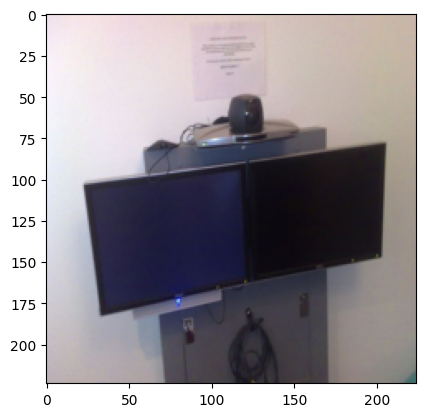

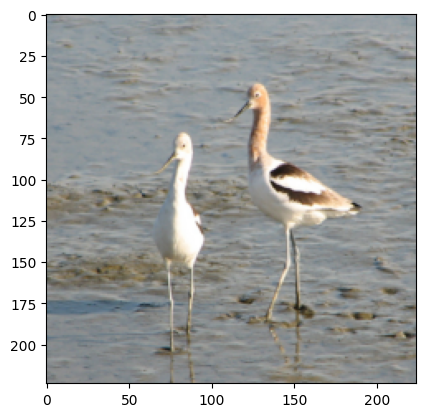

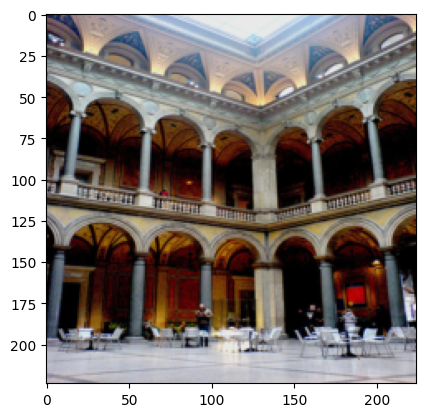

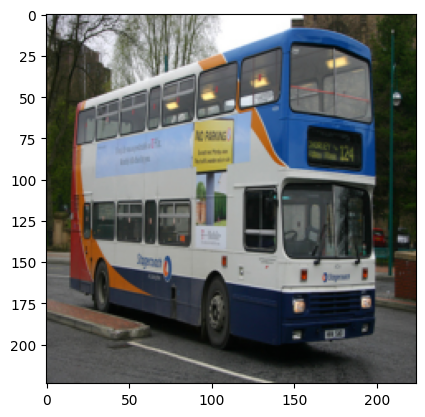

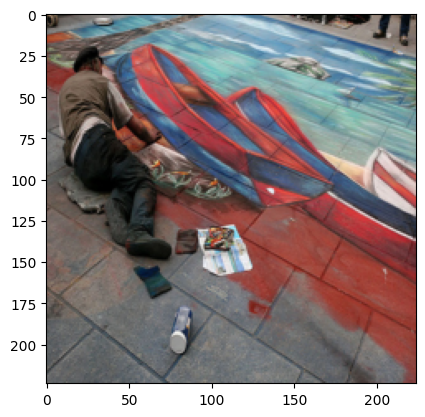

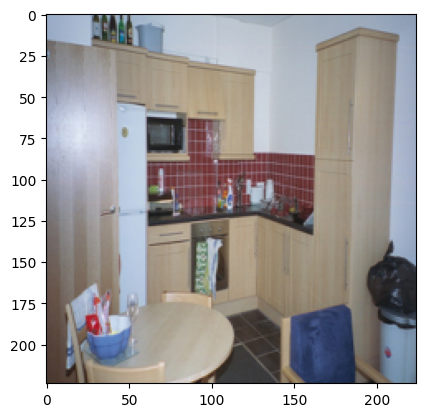

KeyboardInterrupt: 

In [15]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# 创建PascalVOC2012数据集实例
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

pascal_dataset = PascalVOC2012(data_dir='/Users/cengbosen/Desktop/学习资料/VOCdevkit/VOC2012', transform=transform)

# 创建数据加载器
dataloader = DataLoader(pascal_dataset, batch_size=4, shuffle=True)

# 可视化数据
for batch in dataloader:
    images = batch  # 获取图像批次
    for image in images:
        # 转换张量为NumPy数组并调整通道顺序
        image = image.permute(1, 2, 0).numpy()
        # 显示图像
        plt.imshow(image)
        plt.show()
